In [1]:
import numpy as np
import matplotlib.pyplot as plt

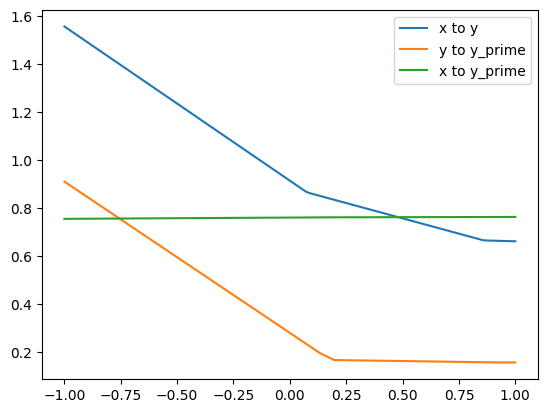

In [29]:
def relu(X):
    return np.where(X > 0, X, 0)

def shallow_nets(X, n_hidden):
    W = -np.random.rand(1,n_hidden)
    b = np.random.rand(1, n_hidden)
    W_final = np.random.rand(n_hidden, 1)
    b_final = np.random.rand(1,1)

    Y = X @ W + b
    Y = relu(Y)
    Y = Y @ W_final + b_final
    return Y


X = np.linspace(-1, 1, num=128).reshape(-1,1)
y_v1 = shallow_nets(X, 3)
y_v2 = shallow_nets(X, 3)
y_v3 = shallow_nets(y_v1, 3)

plt.plot(X.reshape(-1), y_v1.reshape(-1), label='x to y')
plt.plot(X.reshape(-1), y_v2.reshape(-1), label='y to y_prime')
plt.plot(X.reshape(-1), y_v3.reshape(-1), label='x to y_prime')
plt.legend()
plt.show()



In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jaxlib.xla_extension import ArrayImpl
import math
from jax.scipy.special import logsumexp


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (1, n))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(net_sizes, key):
  keys = random.split(key, len(net_sizes))
  return [
     random_layer_params(m, n, k) 
     for (m,n), k in zip(net_sizes, keys)
   ]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')



In [2]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def sigmoid(x):
  return 1 / (1 + jnp.exp(-x))


def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, x_input):
    activations = x_input
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.tanh(logits)

@jit
def loss_func(params, x_input, targets):
  preds = predict(params, x_input)
  return mse(preds, targets)

In [3]:
import numpy as np
import math

def generate_sine_data(num_samples):
  X = jnp.linspace(0, 2 * math.pi, num=num_samples).reshape(-1,1)
  y = jnp.sin(X)
  return X,y

def generate_scale_translate(num_samples):
  X = jnp.linspace(0, 2 * math.pi, num=num_samples).reshape(-1,1)
  y = jnp.cos(X)
  return X,y

def update_weights(params, x, y, learning_rate):
  grads = grad(loss_func)(params, x, y)
  return [(w - learning_rate * dw, b - learning_rate * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(params, num_samples, num_epochs, step_display):
  learning_rate = 0.01
  X,y = generate_sine_data(num_samples)

  for curr_epoch in range(1, num_epochs + 1):
    loss = loss_func(params, X, y)
    params = update_weights(params, X, y, learning_rate)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def parameter_sizes(params):
  layer_depth = len(params)
  for layer_num, layer in enumerate(params, start=1):
    weight_dims = layer[0].shape
    bias_dims = layer[1].shape

    print(f'[{layer_num}/{layer_depth}] weight_dims = {weight_dims}, bias_dims = {bias_dims}')

In [4]:
# Network initial parameters
num_hidden = 3
net_sizes = [
  (1, num_hidden),
  (num_hidden, 1),
]

random_seed = np.random.randint(0, 1024)
params_v1 = init_network_params(net_sizes, random.PRNGKey(random_seed))

random_seed = np.random.randint(0, 1024)
params_v2 = init_network_params(net_sizes, random.PRNGKey(random_seed))

epoch_per_round = 1024
num_training_samples = 1024
step_display = 100

X_test_v1, y_test_v1 = generate_sine_data(256)
X_test_v2, y_test_v2 = generate_sine_data(256)
params_v1 = train_network(params_v1, num_training_samples, epoch_per_round, step_display)
params_v2 = train_network(params_v2, num_training_samples, epoch_per_round, step_display)

y_pred_v1 = predict(params_v1, X_test_v1)
y_pred_v2 = predict(params_v2, X_test_v2)
y_pred_chain = predict(params_v2, y_pred_v1)

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2024-02-02 21:06:11.128121: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M3 Max

systemMemory: 36.00 GB
maxCacheSize: 13.50 GB

[100/1024] Loss: 0.49702560901641846
[200/1024] Loss: 0.42984506487846375
[300/1024] Loss: 0.2997341454029083
[400/1024] Loss: 0.22601042687892914
[500/1024] Loss: 0.18652182817459106
[600/1024] Loss: 0.16321417689323425
[700/1024] Loss: 0.14799749851226807
[800/1024] Loss: 0.1372632086277008
[900/1024] Loss: 0.12925554811954498
[1000/1024] Loss: 0.12303724884986877
[100/1024] Loss: 0.48946741223335266
[200/1024] Loss: 0.3750372529029846
[300/1024] Loss: 0.2659204304218292
[400/1024] Loss: 0.2077386975288391
[500/1024] Loss: 0.17567116022109985
[600/1024] Loss: 0.1560065597295761
[700/1024] Loss: 0.14277702569961548
[800/1024] Loss: 0.13324511051177979
[900/1024] Loss: 0.1260313093662262
[1000/1024] Loss: 0.12037492543458939


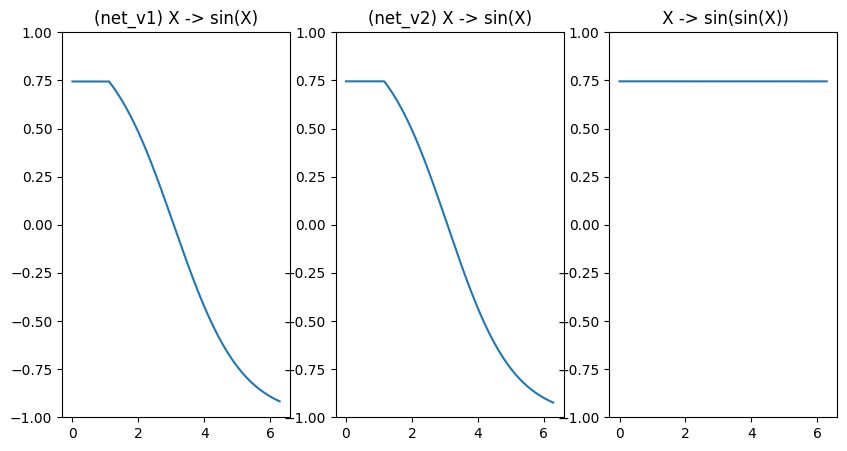

In [6]:
import matplotlib.pyplot as plt

figsize = (10,5)
fig, axs = plt.subplots(1, 3, figsize=figsize)
axs[0].plot(X_test_v1.reshape(-1), y_pred_v1.reshape(-1))
axs[0].set_title('(net_v1) X -> sin(X)')
axs[0].set_ylim([-1, 1])

axs[1].plot(X_test_v2.reshape(-1), y_pred_v2.reshape(-1))
axs[1].set_title('(net_v2) X -> sin(X)')
axs[1].set_ylim([-1, 1])

axs[2].plot(X_test_v1.reshape(-1), y_pred_chain.reshape(-1))
axs[2].set_title(' X -> sin(sin(X))')
axs[2].set_ylim([-1, 1])
plt.show()